In [1]:
import numpy as np
from pyrex.core import main
import matplotlib.pyplot as plt
from qcextender.dimensionlesswaveform import DimensionlessWaveform

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

In [2]:
sims = ['SXS:BBH:1358', 'SXS:BBH:1365', 'SXS:BBH:1372', 'SXS:BBH:1359', 'SXS:BBH:1366', 'SXS:BBH:1360', 'SXS:BBH:1367', 'SXS:BBH:1361']
eccentricities = [0.099, 0.06, 0.092, 0.1, 0.095, 0.142, 0.096, 0.144] # These come from a fit
masses = np.linspace(25, 150, 14)
distance, inclination, coa_phase = 10, 0, 0
f_lower=25
mismatches = {}
for s, eccentricity in zip(sims, eccentricities):
    sim = DimensionlessWaveform.from_sim(s)
    
    q = sim.metadata["q"]
    spin1=(0,0,0)
    spin2=(0,0,0)

    mismatch_seob, mismatch_phen = [], []
    for total_mass in masses:
        if q < 1:
            q = 1/q
        mass1 = q * total_mass / (q + 1)
        mass2 = total_mass / (q + 1)

        kwargs = {'mass1':mass1,'mass2':mass2,'eccentricity':eccentricity,'spin1':spin1,'spin2':spin2,'inclination':inclination,'distance':distance,'coa_phase':coa_phase,"delta_t": 1.0 / 20000, "f_ref":25, "f_lower":25}

        phen_ecc = main("IMRPhenomD", [(2,2)], **kwargs)
        seob_ecc = main("SEOBNRv4", [(2, 2)],**kwargs)
        dsim = sim.to_Waveform(f_lower, total_mass, distance, inclination, coa_phase)

        mismatch_phen.append(1 - phen_ecc.match(dsim, f_lower))
        mismatch_seob.append(1 - seob_ecc.match(dsim, f_lower))
    mismatches[eccentricity] = (mismatch_phen, mismatch_seob)


Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/sxs/simulations/simulation.py:483: UserWarning: 
Closest simulation (SXS:BBH:2606) is fairly distant: 0.0501
  warn(f"\nClosest simulation ({d.index[0]}) is fairly distant: {d.iloc[0]:.3g}")
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/sxs/simulations/simulation.py:236: UserWarning: 
Simulation 'SXS:BBH:1361v3.0' is being automatically superseded by 'SXS:BBH:2606'.
The distance between them in the given metadata metric is 0.0501.
  warn(message)


In [3]:
print(mismatches)

{0.099: ([np.float64(0.19835575668721384), np.float64(0.16284178409668515), np.float64(0.09924083486860535), np.float64(0.07567624505433046), np.float64(0.10163130147817367), np.float64(0.02638902515628394), np.float64(0.02797011178909814), np.float64(0.09499562413775398), np.float64(0.06905282033089799), np.float64(0.052504628164506406), np.float64(0.047912965632936455), np.float64(0.019915026604168662), np.float64(0.03478288606207147), np.float64(0.005801686975252518)], [np.float64(0.18458173438011238), np.float64(0.14716716677225383), np.float64(0.07799438071372511), np.float64(0.05807486260860739), np.float64(0.08621589078836733), np.float64(0.024078564928061597), np.float64(0.026911565440736362), np.float64(0.0904145970601482), np.float64(0.0778438409337423), np.float64(0.05267273898200431), np.float64(0.0417430745784142), np.float64(0.023187377008243026), np.float64(0.029674359330963185), np.float64(0.011754704973541141)]), 0.06: ([np.float64(0.17788942116614193), np.float64(0.12

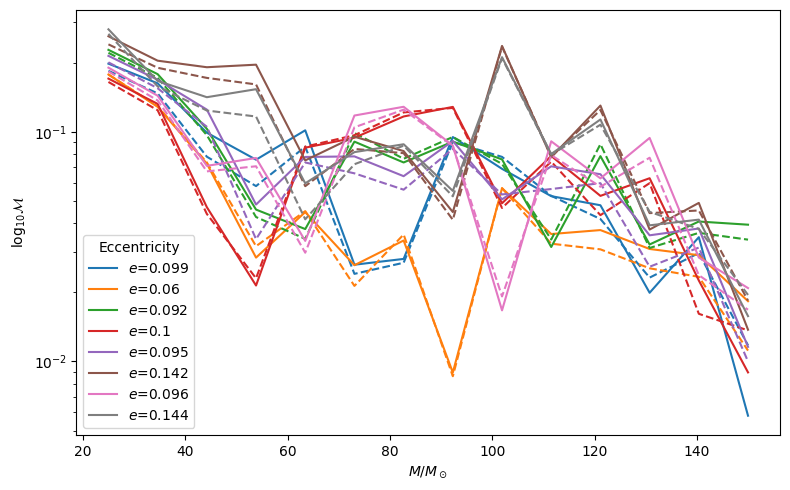

In [4]:
linestyles = {
    "SEOB": "--",
    "Phenom": "-"
}
plt.figure(figsize=(8, 5))
legend_handles = []
for eccentricity, (mismatch_phen, mismatch_seob) in mismatches.items():
    line_phen, = plt.plot(masses, mismatch_phen, linestyle=linestyles["Phenom"])
    plt.plot(masses, mismatch_seob, linestyle=linestyles["SEOB"], color=line_phen.get_color())
    legend_handles.append((line_phen, fr"$e$={eccentricity}"))

plt.legend(*zip(*legend_handles), title="Eccentricity")
plt.yscale("log")
# plt.xlim(25, 150)
plt.xlabel(r"$M/M_\odot$")
plt.ylabel(r"$\text{log}_{10} \mathcal{M}$")
plt.tight_layout()
plt.show()


In [5]:
# plt.figure(figsize=(10, 4))
# plt.plot(phen_ecc.time, seob_ecc.h22, label="SEOBNR")
# plt.plot(t_phen, phen_ecc.h22, label="Phenom")
# plt.plot(dsim.time, dsim[2, 2], label="NR simulation")
# plt.ylim(-1e-18, 1e-18)

# plt.legend()
# plt.tight_layout()
# plt.show()